In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
L = 20
n_steps = 1500
output_interval = 100
samples_per_temp = 300
temp_range = np.linspace(1.5, 3.5, 20)

In [14]:
def initial_state(N):
    return np.random.choice([-1, 1], size=(N, N)).astype(np.int8)

@jit(nopython=True)
def mcmc_step(config, beta):
    N = config.shape[0]
    for _ in range(N * N):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        s = config[i, j]
        nn = (config[(i+1)%N, j] + config[(i-1)%N, j] +
              config[i, (j+1)%N] + config[i, (j-1)%N])
        dE = 2 * s * nn
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            config[i, j] = -s
    return config


def generate_data(temps, n_samples):
    data, labels = [], []
    for T in temps:
        config = initial_state(L)
        beta = 1.0 / T
        for _ in range(n_steps):
            mcmc_step(config, beta)
        for _ in range(n_samples):
            for _ in range(output_interval):
                mcmc_step(config, beta)
            data.append(config.copy())
            labels.append(T)
    return np.array(data), np.array(labels)

In [15]:
X, T_labels = generate_data(temp_range, samples_per_temp)
X_flat = X.reshape(len(X), -1)


pca = PCA(n_components=2)
Z = pca.fit_transform(X_flat)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.38385575 0.01534384]


In [16]:
unique_T = np.unique(T_labels)
mean_abs_pc1, var_pc1 = [], []

for T in unique_T:
    z1 = Z[T_labels == T, 0]
    mean_abs_pc1.append(np.mean(np.abs(z1)))
    var_pc1.append(np.var(z1))

mean_abs_pc1 = np.array(mean_abs_pc1)
var_pc1 = np.array(var_pc1)

Tc_pca = unique_T[np.argmax(var_pc1)]
print(f"Estimated Tc from PCA variance peak: {Tc_pca:.3f}")


Estimated Tc from PCA variance peak: 2.237


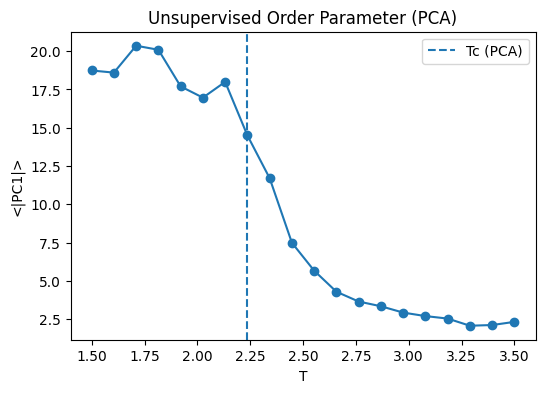

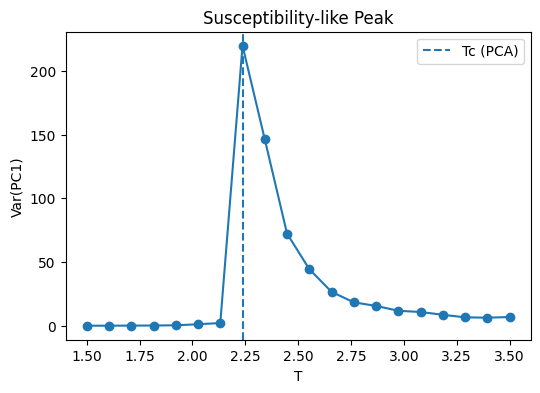

In [17]:
plt.figure(figsize=(6,4))
plt.plot(unique_T, mean_abs_pc1, 'o-')
plt.axvline(Tc_pca, ls='--', label='Tc (PCA)')
plt.xlabel('T'); plt.ylabel('<|PC1|>')
plt.title('Unsupervised Order Parameter (PCA)')
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(unique_T, var_pc1, 'o-')
plt.axvline(Tc_pca, ls='--', label='Tc (PCA)')
plt.xlabel('T'); plt.ylabel('Var(PC1)')
plt.title('Susceptibility-like Peak')
plt.legend(); plt.show()

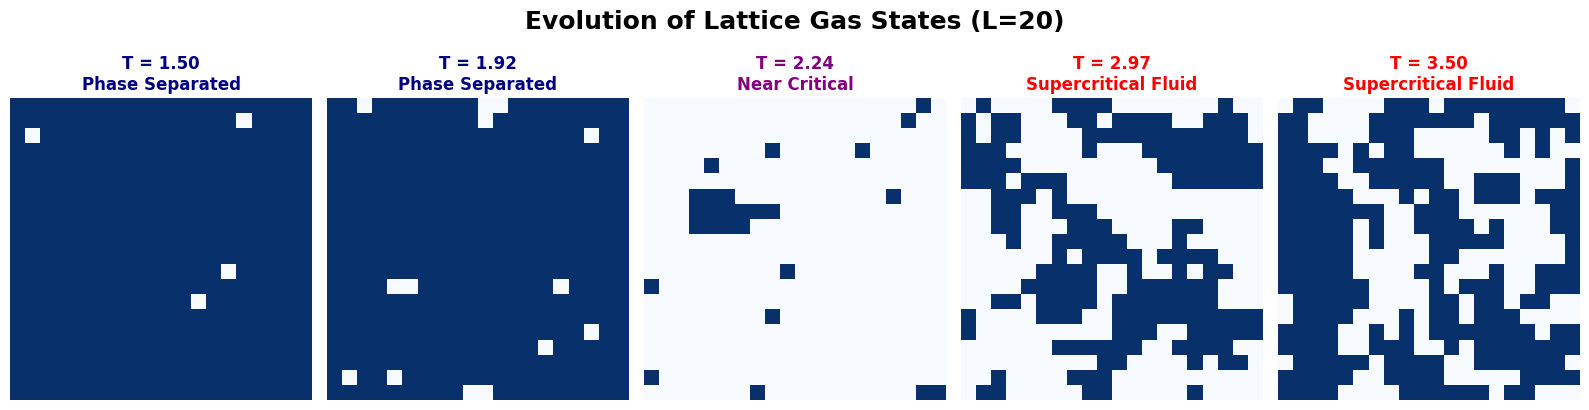

In [18]:
selected_temps = [1.50, 1.92, 2.24, 2.97, 3.50]
sorted_indices = np.argsort(T_labels)
X_sorted = X[sorted_indices]
T_sorted = T_labels[sorted_indices]


indices = []
for T in selected_temps:
    idx = np.argmin(np.abs(T_sorted - T))
    indices.append(idx)


plt.figure(figsize=(16, 4))
plt.suptitle(
    f"Evolution of Lattice Gas States (L={L})",
    fontsize=18, fontweight="bold", y=1.05
)

for i, idx in enumerate(indices):
    config = X_sorted[idx]
    T = T_sorted[idx]

    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(config, cmap='Blues', vmin=-1, vmax=1)
    ax.axis('off')

    # Phase label
    if T < Tc_pca :
        phase_label = "Phase Separated"
        color = "navy"
    elif T > Tc_pca :
        phase_label = "Supercritical Fluid"
        color = "red"
    else:
        phase_label = "Near Critical"
        color = "purple"

    ax.set_title(
        f"T = {T:.2f}\n{phase_label}",
        fontsize=12,
        fontweight='bold',
        color=color
    )

plt.tight_layout()
plt.show()


In [19]:
y_binary = (T_labels > Tc_pca).astype(int) 
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split( X_flat, y_binary, T_labels, test_size=0.3, random_state=0 )

svm = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"SVM Test Accuracy: {acc*100:.2f}%")

SVM Test Accuracy: 96.11%


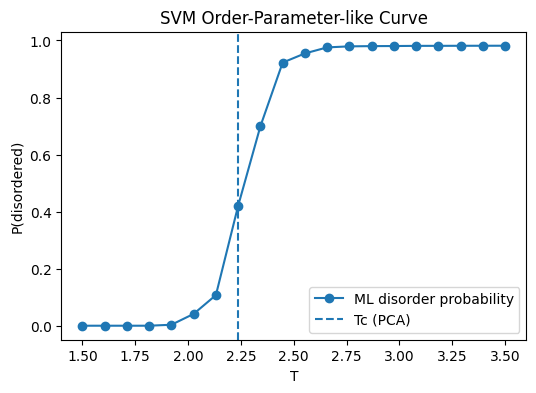

In [20]:
probs = svm.predict_proba(X_test)[:,1]
ml_curve = []

for T in unique_T:
    ml_curve.append(np.mean(probs[T_test == T]))

plt.figure(figsize=(6,4))
plt.plot(unique_T, ml_curve, 'o-', label='ML disorder probability')
plt.axvline(Tc_pca, ls='--', label='Tc (PCA)')
plt.xlabel('T'); plt.ylabel('P(disordered)')
plt.title('SVM Order-Parameter-like Curve')
plt.legend(); plt.show()

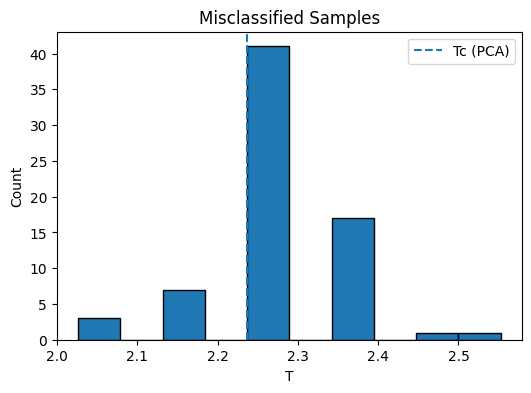

In [21]:
wrong = (y_pred != y_test)

plt.figure(figsize=(6,4))
plt.hist(T_test[wrong], bins=10, edgecolor='black')
plt.axvline(Tc_pca, ls='--', label='Tc (PCA)')
plt.xlabel('T'); plt.ylabel('Count')
plt.title('Misclassified Samples')
plt.legend(); plt.show()


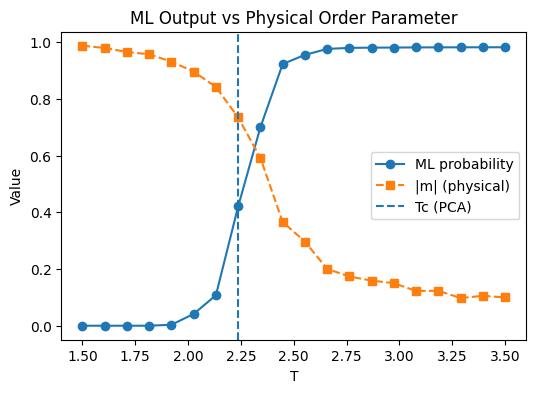

Correlation (ML vs physical order parameter): -0.980


In [22]:
magnetization = np.abs(np.mean(X_test, axis=1))

mean_mag, mean_prob = [], []
for T in unique_T:
    mask = (T_test == T)
    mean_mag.append(np.mean(magnetization[mask]))
    mean_prob.append(np.mean(probs[mask]))

plt.figure(figsize=(6,4))
plt.plot(unique_T, mean_prob, 'o-', label='ML probability')
plt.plot(unique_T, mean_mag, 's--', label='|m| (physical)')
plt.axvline(Tc_pca, ls='--', label='Tc (PCA)')
plt.xlabel('T'); plt.ylabel('Value')
plt.title('ML Output vs Physical Order Parameter')
plt.legend(); plt.show()

corr = np.corrcoef(mean_prob, mean_mag)[0,1]
print(f"Correlation (ML vs physical order parameter): {corr:.3f}")